In [1]:
#!/usr/bin/env python
"""
@author: Jayant Gupta
last update: 02.06.2021
"""

'\n@author: Jayant Gupta\nlast update: 02.06.2021\n'

In [2]:
# Import necessary libraries
import tensorflow as tf
import os
import random
import numpy as np
import math

import models
 
from tqdm import tqdm 
import json

from skimage.io import imread, imshow, show
from skimage.transform import resize
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from PIL import Image

# Handles reading large number of files.
Image.MAX_IMAGE_PIXELS = 219494175 

In [3]:
seed = 42
np.random.seed = seed

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
IMG_INDEX = "RGB"

# This function creates a dictionary to store images and their mask.
# This function is curated to handle train images *.tif format and 
# mask file in *.jpeg format
def get_in_out_dict(img_dir=json.load(open('config.json'))['filepaths']['input_imagery_dir'], 
                    mask_dir=json.load(open('config.json'))['filepaths']['default_masks_dir'], 
                    indices_dir=None, 
                    index_type=None,
                    in_folder=''):
    in_out_dict = {}
    img_path = os.path.join(img_dir, in_folder) # img_dir/in_folder
    for img_filename in os.listdir(img_path):
        in_file = os.path.join(img_path, img_filename) # img_dir/in_folder/img_filename
        if os.path.isdir(in_file):
            if IMG_CHANNELS > 3:
                in_out_dict.update(get_in_out_dict(indices_dir=indices_dir, index_type=IMG_INDEX, in_folder=os.path.join(in_folder, img_filename)))
            else:
                in_out_dict.update(get_in_out_dict(in_folder=os.path.join(in_folder, img_filename)))
        if in_file.endswith(".tif") is not True:
            continue
        key = img_filename.split('.')[0]
        in_out_dict[key] = []
        in_out_dict[key].append(in_file)
        if IMG_CHANNELS > 3:
            indices_path = os.path.join(indices_dir, in_folder) # indices_dir/in_folder
            in_out_dict[key].append(
                os.path.join(indices_path, [index for index in os.listdir(indices_path) if key in index and Index_Type in index][0]))
        mask_path = os.path.join(mask_dir, in_folder) # mask_path/in_folder
        in_out_dict[key].append(
            os.path.join(mask_path, [mask for mask in os.listdir(mask_path) if key in mask][0]))

    return in_out_dict

in_out_dict = {}
if IMG_CHANNELS > 3:
    indices_dir = json.load(open('config.json'))['filepaths']['default_indices_dir']
    in_out_dict = get_in_out_dict(indices_dir=indices_dir, index_type=IMG_INDEX)
else:
    in_out_dict = get_in_out_dict()

for key in list(in_out_dict.keys())[0:5]:
        print(in_out_dict[key])

['datasets/imagery\\MN_raster_Hennepin_North\\120_23_13_01.tif', 'outputs/masks\\MN_raster_Hennepin_North\\120_23_13_01_mask.jpeg']
['datasets/imagery\\MN_raster_Hennepin_North\\120_23_13_02.tif', 'outputs/masks\\MN_raster_Hennepin_North\\120_23_13_02_mask.jpeg']
['datasets/imagery\\MN_raster_Hennepin_North\\120_23_13_03.tif', 'outputs/masks\\MN_raster_Hennepin_North\\120_23_13_03_mask.jpeg']
['datasets/imagery\\MN_raster_Hennepin_North\\120_23_13_04.tif', 'outputs/masks\\MN_raster_Hennepin_North\\120_23_13_04_mask.jpeg']
['datasets/imagery\\MN_raster_Hennepin_North\\120_23_14_01.tif', 'outputs/masks\\MN_raster_Hennepin_North\\120_23_14_01_mask.jpeg']


In [4]:
def join_image_and_index(img_path, index_path):
    image = Image.open(img_path) # Using Pillow Image object
    image = image.resize((IMG_HEIGHT, IMG_WIDTH)) # 
    image_array = np.asarray(image)/255.

    index = Image.open(index_path) # Using Pillow Image object
    index = index.resize((IMG_HEIGHT, IMG_WIDTH))
    index_array = np.asarray(index)
    return np.dstack((image_array, index_array))

# Function to read the data from image_mask_pair file paths.
def read_data(in_out_dict):
    X_train = np.zeros((len(in_out_dict), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    Y_train = np.zeros((len(in_out_dict), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    keys = in_out_dict.keys()

    print('Resizing training images and masks')
    n = 0
    for key, value in tqdm(in_out_dict.items()):
        print(key)
        if IMG_CHANNELS > 3:
            [img_path, index_path, mask_path] = value
            X_train[n] = join_image_and_index(img_path, index_path)
        else:
            [img_path, mask_path] = value
            image = Image.open(img_path) # Using Pillow Image object
            image = image.resize((IMG_HEIGHT, IMG_WIDTH)) # 
            X_train[n] = np.asarray(image)/255.
        mask = Image.open(mask_path) # Using Pillow Image object
        mask = mask.resize((IMG_HEIGHT, IMG_WIDTH))
        mask = np.array(mask)
        mask = mask.reshape(256, 256, 1)
        mask_bool = mask > 0          
        Y_train[n] = mask_bool 
        n += 1
    return X_train, Y_train

X_train_in, Y_train_in = read_data(in_out_dict)

  0%|          | 0/72 [00:00<?, ?it/s]Resizing training images and masks
120_23_13_01
100%|██████████| 72/72 [03:09<00:00,  2.64s/it]


In [5]:
# Need to run once. Generate training, validation, and test dataset.
def generate_train_val_test(X_train, Y_train):
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state=1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.12, random_state=1)
    print("Train Size = {0}, Test size = {1}, Validation size = {2}".format(len(X_train), len(X_test), len(X_val)))
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train_split, Y_train_split, X_val, Y_val, X_test, Y_test = generate_train_val_test(X_train_in, Y_train_in)

outfile = json.load(open('config.json'))['filepaths']['default_pyobjects'] + '/Hennepin_North.npz'
np.savez(outfile ,X_train=X_train_split, Y_train=Y_train_split, X_val=X_val, Y_val=Y_val, X_test=X_test, Y_test=Y_test)
npzfile = np.load(outfile)
print(npzfile.files)
X_train = npzfile['X_train']
Y_train = npzfile['Y_train']
X_test = npzfile['X_test']
Y_test = npzfile['Y_test']
X_val = npzfile['X_val']
Y_val = npzfile['Y_val']

Train Size = 56, Test size = 8, Validation size = 8
['X_train', 'Y_train', 'X_val', 'Y_val', 'X_test', 'Y_test']


In [ ]:
# Samples the input data.
for (X, Y, Title) in [(X_train, Y_train, "Train"), (X_test, Y_test, "Test"), (X_val, Y_val, "Validation")]:
    print("Sampling the " + Title + " data")
    #image_x = random.randint(0, len(X)-1)
    #plt.imshow(X[image_x][:,:,:3])
    for i in range(4):
        plt.imshow(X[i][:,:,:3])
        plt.title("RGB for "+Title)
        plt.figure()
        plt.imshow(np.squeeze(Y[i]))
        plt.title("Mask label for "+Title)
        plt.show()
    for c in range(IMG_CHANNELS-3):
        art = plt.imshow(X[i][:,:,3:4+c], cmap ='plasma')
        plt.colorbar(art)
        plt.title("VI for "+Title+" ("+IMG_INDEX+")")
        plt.figure()
    

In [ ]:
#class CustomCallback(keras.callbacks.Callback):
#    def on_train_batch_begin(self, batch, logs=None):
#        if not hasattr(self.model.optimizer, "lr"):
#            raise ValueError('Optimizer must have a "lr" attribute.')
#        lr = float(tf.keras.backend.get_value(self.model.optimizer_learning_rate))
# sample_weights        

# Generate a UNetS model
unets_model = models.UNetS(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/MPLS-UNetS-HNE.h5', verbose=1, save_best_only=True)]

# Check sample weighting
#sample_weight = np.ones(shape=(len(Y_train),))

results = unets_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=8, epochs=10, callbacks=callbacks)

####################################

In [6]:
# Generate a UNet model
unet_model = models.UNet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

################################

#class CustomCallback(keras.callbacks.Callback):
#    def on_train_batch_begin(self, batch, logs=None):
#        if not hasattr(self.model.optimizer, "lr"):
#            raise ValueError('Optimizer must have a "lr" attribute.')
#        lr = float(tf.keras.backend.get_value(self.model.optimizer_learning_rate))
# sample_weights        

#Modelcheckpoint
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/Users/jayantgupta/SVANN/model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/MPLS-UNet-HN+HNE.h5', verbose=1, save_best_only=True)]

# Check sample weighting
# sample_weight = np.ones(shape=(len(Y_train),))

results = unet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=10, callbacks=callbacks)

####################################

Epoch 1/10
4/4 [==============================] - 27s 6s/step - loss: 0.7413 - accuracy: 0.6012 - val_loss: 0.6242 - val_accuracy: 0.7371

Epoch 00001: val_loss improved from inf to 0.62416, saving model to outputs/Checkpoints/RGB\MPLS-UNet-HN+HNE.h5
Epoch 2/10
4/4 [==============================] - 23s 6s/step - loss: 0.5923 - accuracy: 0.7759 - val_loss: 0.6072 - val_accuracy: 0.7373

Epoch 00002: val_loss improved from 0.62416 to 0.60723, saving model to outputs/Checkpoints/RGB\MPLS-UNet-HN+HNE.h5
Epoch 3/10
4/4 [==============================] - 24s 6s/step - loss: 0.5715 - accuracy: 0.7596 - val_loss: 0.5717 - val_accuracy: 0.7379

Epoch 00003: val_loss improved from 0.60723 to 0.57171, saving model to outputs/Checkpoints/RGB\MPLS-UNet-HN+HNE.h5
Epoch 4/10
4/4 [==============================] - 23s 6s/step - loss: 0.5249 - accuracy: 0.7814 - val_loss: 0.5725 - val_accuracy: 0.7386

Epoch 00004: val_loss did not improve from 0.57171
Epoch 5/10
4/4 [==============================] -

1/1 [==============================] - 1s 615ms/step
Best Threshold=0.247090, G-Mean=0.569


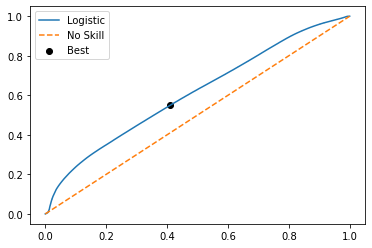

In [7]:

unet_model = models.UNet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
weight_file = json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/MPLS-UNet-HN+HNE.h5'
unet_model.load_weights(weight_file)

preds_train = np.squeeze(unet_model.predict(X_train, verbose=1))
preds_val = np.squeeze(unet_model.predict(X_val, verbose=1))
preds_test = np.squeeze(unet_model.predict(X_test, verbose=1))

#dices = []
#precisions = []
#recalls = []
#[tmin, tmax] = np.percentile(preds_train, [10, 90])
#thrs = np.arange(tmin, tmax, 0.001)
#for t in tqdm(thrs):
#    preds_train_t = (preds_train > np.full(preds_train.shape, t)).astype(np.uint8)
#    
#    (tn, fp, fn, tp) = (0, 0, 0, 0)
#    for i in range(len(preds_train_t)):
#        tn_, fp_, fn_, tp_ = confusion_matrix(
#            Y_train[i].astype(int).flatten(), preds_train_t[i].astype(int).flatten(), labels=[0,1]).ravel()
#        tn = tn + tn_
#        fp = fp + fp_
#        fn = fn + fn_
#        tp = tp + tp_
#    print('%d, %d, %d, %d'%(tn, fp, fn, tp))
#    precision = tp/(tp+fp)
#    recall = tp/(tp+fn)
#    f1 = 2*(precision*recall)/(precision+recall)
#    #specificity = tn/(tn+fp)
#    #accuracy = (tn+tp)/(tn+fp+fn+tp)
#    dices.append(f1)
#    precisions.append(precision)
#    recalls.append(recall)
#    print('Threshold: %0.3f, F1: %0.3f, Precision: %0.3f, Recall: %0.3f'% (t, f1, precision, recall))
ns_probs = np.zeros(Y_train.shape)
ns_fpr, ns_tpr, _ = roc_curve(np.squeeze(Y_train).flatten(), ns_probs.flatten())
fpr, tpr, thresholds = roc_curve(np.squeeze(Y_train).flatten(), preds_train.flatten())
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.plot(fpr, tpr, label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.legend()
plt.show
best_threshold = thresholds[ix]
#best_threshold = thrs[np.argmin(np.abs(np.array(precisions)-np.array(recalls)))]
#print('Best Threshold: %0.3f' % (best_threshold))
#plt.title('Performance curves for UNetS on HN')
#plt.plot(thrs, dices, label='F1')
#plt.plot(thrs, precisions, label='Precision')
#plt.plot(thrs, recalls, label='Recall')
#plt.axvline(x=best_threshold, color='r', label='Best Threshold')
#plt.ylabel('Metric Score')
#plt.xlabel('Threshold Value')
#plt.legend()
#plt.show()

preds_train_t = (preds_train > np.full(preds_train.shape, best_threshold)).astype(np.uint8)
preds_val_t = (preds_val > np.full(preds_val.shape, best_threshold)).astype(np.uint8)
preds_test_t = (preds_test > np.full(preds_test.shape, best_threshold)).astype(np.uint8)

# Perform a sanity check on some random training samples
#for ix in range(len(preds_train_t)):
#    plt.ioff()
#    fig, axs = plt.subplots(2, 3, figsize=(16, 10), squeeze=True)
#    fig.suptitle('%s with threshold: %0.3f' % (IMG_INDEX, best_threshold))
#    axs[0, 0].imshow(X_train[ix][:,:,:3])
#    axs[0, 0].set_title("Input imagery")
#    if IMG_CHANNELS > 3:
#        axs[0, 1].imshow(X_train[ix][:,:,3:4])
#        axs[0, 1].set_title("Input index")
#    axs[0, 2].imshow(Y_train[ix])
#    axs[0, 2].set_title("Binary mask label")
#    axs[1, 0].imshow(preds_train[ix])
#    axs[1, 0].set_title('Prediction values')
#    axs[1, 1].imshow(preds_train_t[ix])
#    axs[1, 1].set_title('Binary prediction')
#    cm = np.squeeze(Y_train[ix]).astype(int)-2*np.squeeze(preds_train_t[ix]).astype(int)
#    tn_, fp_, fn_, tp_ = confusion_matrix(Y_train[ix].astype(int).flatten(), preds_train_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
#    precision = tp_/(tp_+fp_)
#    recall = tp_/(tp_+fn_)
#    f1 = 2*(precision*recall)/(precision+recall)
#    axs[1, 2].imshow(cm, cmap='RdBu', interpolation='gaussian')
#    axs[1, 2].set_title('Confusion Matrix (f1: %0.3f)\nLight Red=tp, Light Blue=tn, Red=fp, Blue=fn' % (f1))
#    plt.savefig('outputs/plots/'+str(ix)+'/UNetS_'+IMG_INDEX+'_'+str(ix))
#    plt.close()
#    break


In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(X_val)-1)
imshow(X_val[ix][:,:,:3])
plt.title("Input imagery")
plt.show()
print("Mask coverage: %0.3f"%(np.mean(Y_val[ix])))
imshow(np.squeeze(Y_val[ix]))
plt.title("Binary mask label")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title('Binary prediction')
plt.show()

In [ ]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(X_val)-1)
imshow(X_test[ix][:,:,:3])
plt.title("Input imagery")
plt.show()
print("Mask coverage: %0.3f"%(np.mean(Y_test[ix])))
imshow(np.squeeze(Y_test[ix]))
plt.title("Binary mask label")
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.title('Binary prediction')
plt.show()

In [8]:
tn = 0.
fp = 0.
fn = 0.
tp = 0.
for ix in range(0, len(preds_test_t)):
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_test[ix].astype(int).flatten(), preds_test_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_

print(tn, fp, fn, tp)

177213.0 144975.0 92361.0 109739.0


In [9]:
tn = 0.
fp = 0.
fn = 0.
tp = 0.
for ix in range(0, len(preds_val_t)):
    #print(ix)
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_val[ix].astype(int).flatten(), preds_val_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_
#    print(tn, fp, fn, tp)

print(tn, fp, fn, tp)

186358.0 200892.0 52131.0 84907.0


In [ ]:
# Selecting test data samples
# Need to run once at the start
# print(img_mask_HCL_pair.keys)

# import shutil

# TEST_HCL_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/img'
# TEST_HCL_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/mask'

# TEST_HCR_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/img'
# TEST_HCR_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/mask'

# test_samples_HCL = random.choices(list(img_mask_HCL_pair.keys()), k=98)
# for sample in test_samples_HCL:
#     try:
#         img_path = img_mask_HCL_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCL_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
#     #print(img_path)
#     #print(img_test_path)

#         mask_path = img_mask_HCL_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCL_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)
#     except:
#         print(sample)
#     #break;

# test_samples_HCR = random.choices(list(img_mask_HCR_pair.keys()), k=98)
# for sample in test_samples_HCR:
#     try:
#         img_path = img_mask_HCR_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCR_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
    
#         mask_path = img_mask_HCR_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCR_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)    
#     except:
#         print(sample)